## Importing Necessary Libraries

In [2]:
from warnings import filterwarnings
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", lambda  x: '%.2f' % x)

## Uploading the Dataset

In [3]:
reviews = pd.read_excel("amazon.xlsx")
reviews.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


## Text Pre-Processing

In [5]:
reviews["Review"] = reviews["Review"].str.lower() # Normalizing
reviews['Review'].str.replace("[^\w\s]", "") # Punctuation
reviews["Review"].str.replace("[\d]", "") # Numbers

from nltk.corpus import stopwords

sw = stopwords.words("english")
reviews["Review"] = reviews["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [6]:
from textblob import Word

reviews = reviews[reviews["Review"].str.strip().str.len() > 1]

temp_df = pd.Series(" ".join(reviews["Review"]).split()).value_counts()
drops = temp_df[temp_df <= 100] ## drop the words that are used less than 100
reviews["Review"] = reviews["Review"].apply(lambda x : " ".join(x for x in str(x).split() if x not in drops))
print(reviews)

      Star  HelpFul                                          Title                       Review
0        5        0                                    looks great                        happy
1        5        0  Pattern did not align between the two panels.        good quality material
2        5        0               Imagery is stretched. Still fun.    product bedroom bit still
3        5        0                 Que se ven elegantes muy finas                             
4        5        0                             Wow great purchase        great quality vibrant
...    ...      ...                                            ...                          ...
5606     4        0                                      Recommend                great product
5607     5        0        Terrible , different colors. I returned                    color way
5608     5        0                             Extremely pleasing  great product good quality.
5609     5        0                     

## Lemmatization

In [7]:
reviews["Review"] = reviews["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split() if len(word) > 2]))
reviews["Review"]

0                             happy
1             good quality material
2         product bedroom bit still
3                                  
4             great quality vibrant
                   ...             
5606                  great product
5607                      color way
5608    great product good quality.
5609                 room. love it.
5610     curtain thick enough light
Name: Review, Length: 5605, dtype: object

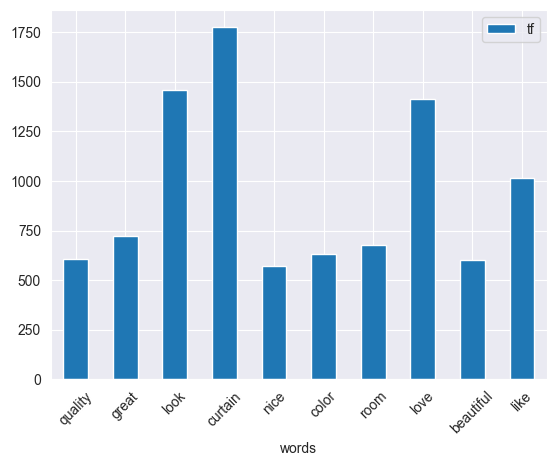

In [8]:
#### Text Visualization ####
import matplotlib.pyplot as plt

tf = reviews["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

# Frekansı 500'den fazla olan kelimeleri bar grafiğinde gösterme
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.xticks(rotation=45)
plt.show()

Shows the frequency of terms.

In [9]:
tf.head()

,words,tf
0,happy,171.00
1,good,453.00
2,quality,609.00
3,material,394.00
4,product,161.00


## WordCloud Visualization

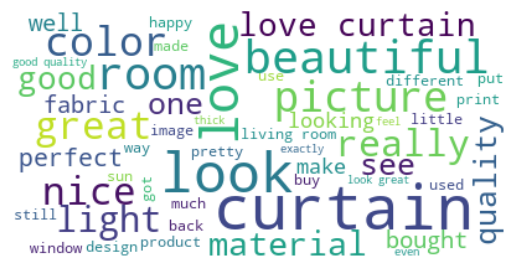

In [10]:
text = " ".join(i for i in reviews.Review)

wordcloud = WordCloud(max_font_size=50,
                      max_words=50,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Sentiment Modeling / Analysis
In this step, the goal is to turn the model learning from unsupervised to supervised here by using labeling.

In [11]:
sia = SentimentIntensityAnalyzer()

scores = reviews["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

In [12]:
reviews["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.00
3   0.00
4   0.82
5   0.00
6   0.62
7   0.42
8   0.00
9   0.36
Name: Review, dtype: float64

In [13]:
reviews["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

reviews["sentiment_label"] = reviews["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

reviews["sentiment_label"].value_counts()

sentiment_label
pos    4042
neg    1563
Name: count, dtype: int64

In [14]:
reviews.groupby("sentiment_label")["Star"].mean()

sentiment_label
neg   4.11
pos   4.52
Name: Star, dtype: float64

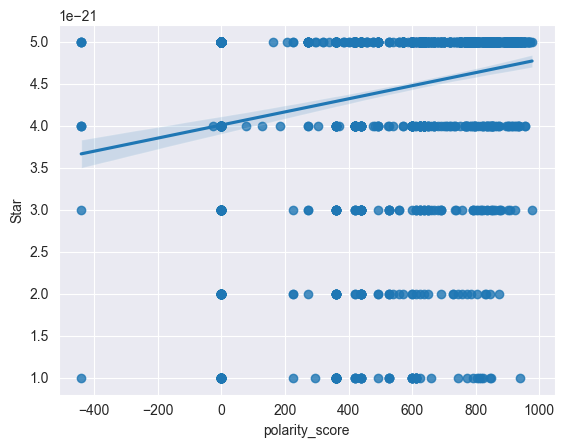

In [40]:
import seaborn as sns

reviews["polarity_score"] = reviews["Review"][0:2000].apply(lambda x: sia.polarity_scores(x)["compound"])*1000
reviews["Star"] = reviews["Star"]/10000

sns.regplot(data=reviews, x="polarity_score", y="Star")
plt.show()

## Feature Engineering / Preparation For Machine Learning
In this step, the aim is to vectorize the data to make it available for machine learning use.

In [183]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews["Review"],
                                                    reviews["sentiment_label"],
                                                    random_state=42)

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_word_vectorizer = TfidfVectorizer().fit(X_train)

X_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X_train)
X_test_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X_test)

## Logistic Regression Modeling

In [185]:
from sklearn.metrics import classification_report
log_model = LogisticRegression().fit(X_train_tf_idf_word, y_train)

y_pred = log_model.predict(X_test_tf_idf_word)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         neg       0.98      1.00      0.99       381
         pos       1.00      0.99      1.00      1021

    accuracy                           1.00      1402
   macro avg       0.99      1.00      0.99      1402
weighted avg       1.00      1.00      1.00      1402



In [186]:
print(cross_val_score(log_model, X_test_tf_idf_word, y_test, cv=5).mean())

0.9786146415861718


## Random Forest Modeling

In [187]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier().fit(X_train_tf_idf_word, y_train)

print(cross_val_score(rf_model, X_test_tf_idf_word, y_test, cv=5, n_jobs=-1).mean())

0.992874936451449


## Testing the Random Forest Model with Count Vectorizer

In [188]:
from sklearn.feature_extraction.text import CountVectorizer

random_review = pd.Series(reviews["Review"].sample(1).values)
yeni_yorum = CountVectorizer().fit(X_train).transform(random_review)
print(random_review)
pred = log_model.predict(yeni_yorum)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

0    different love great room.
dtype: object
Review:  different love great room. 
 Prediction: ['pos']


## Hyperparameter Optimization

In [189]:
empty_rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [8, None],
             "max_features": [7, "auto"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_train_tf_idf_word, y_train)

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_train_tf_idf_word, y_train)

cross_val_score(rf_final, X_train_tf_idf_word, y_train, cv=5, n_jobs=-1).mean()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


np.float64(0.9947638865296415)